In [ ]:
import io
import sys
DATASET_PATH = "Audios/"
DATA_PATH = "Audios/data.json"
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
from collections import Counter
from sklearn import preprocessing
from sklearn.pipeline import FeatureUnion
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, precision_score

from Generate_Family_Clasifi import load_data
from Extract_Data import save_mfcc

In [2]:
save_mfcc(DATASET_PATH,DATA_PATH,num_segments=7)


Processing: Familia Acevedo


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 2.5647798e-05  2.4037521e-05 -1.6709793e-06 ...  1.3716510e-01
  6.0978714e-02  1.5864160e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.00244379  0.00244377 -0.0019488  ...  0.0598404   0.0489769
  0.03040931], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semest

Audios/Familia Acevedo\Acevedo 1.wav, segment:1
Audios/Familia Acevedo\Acevedo 1.wav, segment:2
Audios/Familia Acevedo\Acevedo 1.wav, segment:3
Audios/Familia Acevedo\Acevedo 1.wav, segment:4
Audios/Familia Acevedo\Acevedo 1.wav, segment:5


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-9.7822817e-07  1.8577859e-06 -7.2429566e-06 ...  1.2573921e-02
  1.0006263e-02  8.4850248e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.00738726  0.00552779  0.00439111 ...  0.00190106 -0.00051325
 -0.00217118], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Acevedo\Acevedo 2.wav, segment:1
Audios/Familia Acevedo\Acevedo 2.wav, segment:2
Audios/Familia Acevedo\Acevedo 2.wav, segment:3
Audios/Familia Acevedo\Acevedo 2.wav, segment:4
Audios/Familia Acevedo\Acevedo 2.wav, segment:5
Audios/Familia Acevedo\Acevedo 2.wav, segment:6


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ... -3.0950379e-02
 -2.3885073e-02 -1.7215677e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.01037866 -0.00662529 -0.00533197 ... -0.0318918  -0.03296863
 -0.03530381], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Acevedo\Acevedo 3.wav, segment:1
Audios/Familia Acevedo\Acevedo 3.wav, segment:2
Audios/Familia Acevedo\Acevedo 3.wav, segment:3
Audios/Familia Acevedo\Acevedo 3.wav, segment:4
Audios/Familia Acevedo\Acevedo 3.wav, segment:5
Audios/Familia Acevedo\Acevedo 3.wav, segment:6
Audios/Familia Acevedo\Acevedo 3.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ...  4.8369911e-02
  4.6718590e-02  3.5046406e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.0185315  -0.00258378 -0.0244425  ... -0.12957186 -0.14496648
 -0.15405998], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Acevedo\Acevedo 4.wav, segment:1
Audios/Familia Acevedo\Acevedo 4.wav, segment:2
Audios/Familia Acevedo\Acevedo 4.wav, segment:3
Audios/Familia Acevedo\Acevedo 4.wav, segment:4
Audios/Familia Acevedo\Acevedo 4.wav, segment:5
Audios/Familia Acevedo\Acevedo 4.wav, segment:6
Audios/Familia Acevedo\Acevedo 4.wav, segment:7

Processing: Familia Barragan


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ... -8.7806292e-02
 -6.9237724e-02 -5.6698393e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.04922808 -0.04204268 -0.03632461 ... -0.00606848 -0.00369234
 -0.00073027], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Barragan\Barragan 1.wav, segment:1
Audios/Familia Barragan\Barragan 1.wav, segment:2
Audios/Familia Barragan\Barragan 1.wav, segment:3
Audios/Familia Barragan\Barragan 1.wav, segment:4
Audios/Familia Barragan\Barragan 1.wav, segment:5
Audios/Familia Barragan\Barragan 1.wav, segment:6
Audios/Familia Barragan\Barragan 1.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ... -1.1361424e-02
  2.0250671e-03  4.3276059e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.0015009  0.00463057 0.00147913 ... 0.00490422 0.00597896 0.00466546], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Int

Audios/Familia Barragan\Barragan 2.wav, segment:1
Audios/Familia Barragan\Barragan 2.wav, segment:2
Audios/Familia Barragan\Barragan 2.wav, segment:3
Audios/Familia Barragan\Barragan 2.wav, segment:4
Audios/Familia Barragan\Barragan 2.wav, segment:5
Audios/Familia Barragan\Barragan 2.wav, segment:6
Audios/Familia Barragan\Barragan 2.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ... -5.7556279e-02
 -5.3867381e-02 -5.1135719e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.04854336 -0.04498973 -0.03930632 ... -0.2619325  -0.24450292
 -0.21552297], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Barragan\Barragan 3.wav, segment:1
Audios/Familia Barragan\Barragan 3.wav, segment:2
Audios/Familia Barragan\Barragan 3.wav, segment:3
Audios/Familia Barragan\Barragan 3.wav, segment:4
Audios/Familia Barragan\Barragan 3.wav, segment:5
Audios/Familia Barragan\Barragan 3.wav, segment:6
Audios/Familia Barragan\Barragan 3.wav, segment:7

Processing: Familia Bertel


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ... -2.0450056e-02
 -1.2873274e-02 -9.7717987e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.00756232 -0.00225835  0.00854129 ...  0.00021839  0.00033761
  0.00024164], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Bertel\Bertel 1.wav, segment:1
Audios/Familia Bertel\Bertel 1.wav, segment:2
Audios/Familia Bertel\Bertel 1.wav, segment:3
Audios/Familia Bertel\Bertel 1.wav, segment:4
Audios/Familia Bertel\Bertel 1.wav, segment:5
Audios/Familia Bertel\Bertel 1.wav, segment:6


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ...  3.3168301e-03
  2.9576337e-03  2.1926498e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.00116199  0.00042944  0.00013984 ... -0.05508669 -0.04670062
 -0.02529177], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Bertel\Bertel 2.wav, segment:1
Audios/Familia Bertel\Bertel 2.wav, segment:2
Audios/Familia Bertel\Bertel 2.wav, segment:3
Audios/Familia Bertel\Bertel 2.wav, segment:4
Audios/Familia Bertel\Bertel 2.wav, segment:5
Audios/Familia Bertel\Bertel 2.wav, segment:6
Audios/Familia Bertel\Bertel 2.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ...  2.0998299e-02
  1.1359148e-02  4.1164169e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.00298868 -0.0117853  -0.02192639 ... -0.00421119 -0.00422631
 -0.00458604], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Bertel\Bertel 3.wav, segment:1
Audios/Familia Bertel\Bertel 3.wav, segment:2
Audios/Familia Bertel\Bertel 3.wav, segment:3
Audios/Familia Bertel\Bertel 3.wav, segment:4
Audios/Familia Bertel\Bertel 3.wav, segment:5
Audios/Familia Bertel\Bertel 3.wav, segment:6

Processing: Familia Caro


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ...  8.7368168e-02
  7.5953849e-02  6.1227396e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.04593102  0.03233832  0.02131106 ... -0.00482317 -0.00561403
 -0.00582994], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Caro\Caro 1.wav, segment:1
Audios/Familia Caro\Caro 1.wav, segment:2
Audios/Familia Caro\Caro 1.wav, segment:3
Audios/Familia Caro\Caro 1.wav, segment:4
Audios/Familia Caro\Caro 1.wav, segment:5
Audios/Familia Caro\Caro 1.wav, segment:6
Audios/Familia Caro\Caro 1.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ... -2.3735339e-02
 -2.6984433e-02 -3.2266207e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.03540444 -0.03421609 -0.03496719 ... -0.0124131  -0.02072596
 -0.03021195], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Caro\Caro 2.wav, segment:1
Audios/Familia Caro\Caro 2.wav, segment:2
Audios/Familia Caro\Caro 2.wav, segment:3
Audios/Familia Caro\Caro 2.wav, segment:4
Audios/Familia Caro\Caro 2.wav, segment:5
Audios/Familia Caro\Caro 2.wav, segment:6
Audios/Familia Caro\Caro 2.wav, segment:7

Processing: Familia Carrillo


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 4.9635688e-05  3.5032259e-05 -2.5824695e-05 ...  6.4227461e-05
 -6.6534063e-05  7.3436974e-04], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.00130401 0.00151784 0.00165511 ... 0.11358608 0.11353447 0.0972036 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Int

Audios/Familia Carrillo\Carrillo 1.wav, segment:1
Audios/Familia Carrillo\Carrillo 1.wav, segment:2
Audios/Familia Carrillo\Carrillo 1.wav, segment:3
Audios/Familia Carrillo\Carrillo 1.wav, segment:4
Audios/Familia Carrillo\Carrillo 1.wav, segment:5
Audios/Familia Carrillo\Carrillo 1.wav, segment:6
Audios/Familia Carrillo\Carrillo 1.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ... -1.8230372e-03
 -1.0386890e-03  3.1111215e-04], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.00159225 0.00216502 0.00262229 ... 0.00558935 0.00558291 0.0059239 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Int

Audios/Familia Carrillo\Carrillo 2.wav, segment:1
Audios/Familia Carrillo\Carrillo 2.wav, segment:2
Audios/Familia Carrillo\Carrillo 2.wav, segment:3
Audios/Familia Carrillo\Carrillo 2.wav, segment:4
Audios/Familia Carrillo\Carrillo 2.wav, segment:5
Audios/Familia Carrillo\Carrillo 2.wav, segment:6
Audios/Familia Carrillo\Carrillo 2.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.         0.         0.         ... 0.01360181 0.01326487 0.01291587], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.01191356  0.01102341  0.00879976 ... -0.21190055 -0.15619686
 -0.03224767], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artifici

Audios/Familia Carrillo\Carrillo 3.wav, segment:1
Audios/Familia Carrillo\Carrillo 3.wav, segment:2
Audios/Familia Carrillo\Carrillo 3.wav, segment:3
Audios/Familia Carrillo\Carrillo 3.wav, segment:4
Audios/Familia Carrillo\Carrillo 3.wav, segment:5
Audios/Familia Carrillo\Carrillo 3.wav, segment:6
Audios/Familia Carrillo\Carrillo 3.wav, segment:7

Processing: Familia Florez


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.         0.         0.         ... 0.18519567 0.17531058 0.1549309 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.14017819  0.12718937  0.11512248 ... -0.00136948  0.00383613
 -0.01027016], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artifici

Audios/Familia Florez\Florez 1.wav, segment:1
Audios/Familia Florez\Florez 1.wav, segment:2
Audios/Familia Florez\Florez 1.wav, segment:3
Audios/Familia Florez\Florez 1.wav, segment:4
Audios/Familia Florez\Florez 1.wav, segment:5
Audios/Familia Florez\Florez 1.wav, segment:6
Audios/Familia Florez\Florez 1.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.         0.         0.         ... 0.06919353 0.06758408 0.06525448], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.06355861 0.06111829 0.05855125 ... 0.01599004 0.01788613 0.02010618], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proy

Audios/Familia Florez\Florez 2.wav, segment:1
Audios/Familia Florez\Florez 2.wav, segment:2
Audios/Familia Florez\Florez 2.wav, segment:3
Audios/Familia Florez\Florez 2.wav, segment:4
Audios/Familia Florez\Florez 2.wav, segment:5
Audios/Familia Florez\Florez 2.wav, segment:6


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 2.4911596e-05  2.4885667e-05 -2.9839059e-06 ...  1.5593681e-02
  2.3188025e-02  3.0610658e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.03301991  0.02653264  0.01430989 ... -0.02707568  0.02652745
  0.02614655], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Florez\Florez 3.wav, segment:1
Audios/Familia Florez\Florez 3.wav, segment:2
Audios/Familia Florez\Florez 3.wav, segment:3
Audios/Familia Florez\Florez 3.wav, segment:4
Audios/Familia Florez\Florez 3.wav, segment:5
Audios/Familia Florez\Florez 3.wav, segment:6
Audios/Familia Florez\Florez 3.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 1.3409036e-07 -1.7778392e-07  2.2402892e-07 ...  2.2647986e-02
  3.3087350e-02  3.5644352e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.03020527 0.02300667 0.02161798 ... 0.01102824 0.00667046 0.00359845], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Int

Audios/Familia Florez\Florez 4.wav, segment:1
Audios/Familia Florez\Florez 4.wav, segment:2
Audios/Familia Florez\Florez 4.wav, segment:3
Audios/Familia Florez\Florez 4.wav, segment:4
Audios/Familia Florez\Florez 4.wav, segment:5
Audios/Familia Florez\Florez 4.wav, segment:6
Audios/Familia Florez\Florez 4.wav, segment:7

Processing: Familia Gamarra


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.         0.         0.         ... 0.01941643 0.01577836 0.01461357], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.01518985 0.01248033 0.01217723 ... 0.02013142 0.02655468 0.02635593], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proy

Audios/Familia Gamarra\Gamarra 1.wav, segment:1
Audios/Familia Gamarra\Gamarra 1.wav, segment:2
Audios/Familia Gamarra\Gamarra 1.wav, segment:3
Audios/Familia Gamarra\Gamarra 1.wav, segment:4
Audios/Familia Gamarra\Gamarra 1.wav, segment:5


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.         0.         0.         ... 0.03575023 0.03212194 0.02444715], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.02845978  0.02821283  0.02680737 ... -0.00618275 -0.00731525
 -0.00844639], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artifici

Audios/Familia Gamarra\Gamarra 2.wav, segment:1
Audios/Familia Gamarra\Gamarra 2.wav, segment:2
Audios/Familia Gamarra\Gamarra 2.wav, segment:3
Audios/Familia Gamarra\Gamarra 2.wav, segment:4
Audios/Familia Gamarra\Gamarra 2.wav, segment:5
Audios/Familia Gamarra\Gamarra 2.wav, segment:6
Audios/Familia Gamarra\Gamarra 2.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0061565  -0.00369776
 -0.00224369], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.00144858  0.00331279  0.00414774 ...  0.04516035  0.03318819
  0.01895163], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia A

Audios/Familia Gamarra\Gamarra 3.wav, segment:1
Audios/Familia Gamarra\Gamarra 3.wav, segment:2
Audios/Familia Gamarra\Gamarra 3.wav, segment:3
Audios/Familia Gamarra\Gamarra 3.wav, segment:4
Audios/Familia Gamarra\Gamarra 3.wav, segment:5
Audios/Familia Gamarra\Gamarra 3.wav, segment:6
Audios/Familia Gamarra\Gamarra 3.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01077956 -0.01161898
 -0.02510253], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.03145743 -0.0431444  -0.03541599 ...  0.02634269  0.014178
  0.01271708], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Art

Audios/Familia Gamarra\Gamarra 4.wav, segment:1
Audios/Familia Gamarra\Gamarra 4.wav, segment:2
Audios/Familia Gamarra\Gamarra 4.wav, segment:3
Audios/Familia Gamarra\Gamarra 4.wav, segment:4
Audios/Familia Gamarra\Gamarra 4.wav, segment:5
Audios/Familia Gamarra\Gamarra 4.wav, segment:6


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.         0.         0.         ... 0.03514876 0.03536861 0.03427483], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.03229891 0.02916271 0.02670128 ... 0.00514565 0.01209323 0.00154377], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proy

Audios/Familia Gamarra\Gamarra 5.wav, segment:1
Audios/Familia Gamarra\Gamarra 5.wav, segment:2
Audios/Familia Gamarra\Gamarra 5.wav, segment:3
Audios/Familia Gamarra\Gamarra 5.wav, segment:4
Audios/Familia Gamarra\Gamarra 5.wav, segment:5
Audios/Familia Gamarra\Gamarra 5.wav, segment:6
Audios/Familia Gamarra\Gamarra 5.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02496762 -0.02312047
 -0.0255624 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.02640253 -0.02785116 -0.02926913 ... -0.00649061 -0.00644728
 -0.01054042], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia A

Audios/Familia Gamarra\Gamarra 6.wav, segment:1
Audios/Familia Gamarra\Gamarra 6.wav, segment:2
Audios/Familia Gamarra\Gamarra 6.wav, segment:3
Audios/Familia Gamarra\Gamarra 6.wav, segment:4
Audios/Familia Gamarra\Gamarra 6.wav, segment:5
Audios/Familia Gamarra\Gamarra 6.wav, segment:6
Audios/Familia Gamarra\Gamarra 6.wav, segment:7

Processing: Familia Gnecco


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.03466487  0.01218688
 -0.02394307], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.0309335   0.03791572  0.02427611 ...  0.26593202  0.23009695
  0.2063258 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia A

Audios/Familia Gnecco\Gnecco 1.wav, segment:1
Audios/Familia Gnecco\Gnecco 1.wav, segment:2
Audios/Familia Gnecco\Gnecco 1.wav, segment:3
Audios/Familia Gnecco\Gnecco 1.wav, segment:4
Audios/Familia Gnecco\Gnecco 1.wav, segment:5
Audios/Familia Gnecco\Gnecco 1.wav, segment:6


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03180793  0.00223287
 -0.03503222], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.02329244 -0.01264739 -0.04056506 ...  0.0180488   0.07500586
  0.0363318 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia A

Audios/Familia Gnecco\Gnecco 2.wav, segment:1
Audios/Familia Gnecco\Gnecco 2.wav, segment:2
Audios/Familia Gnecco\Gnecco 2.wav, segment:3
Audios/Familia Gnecco\Gnecco 2.wav, segment:4
Audios/Familia Gnecco\Gnecco 2.wav, segment:5
Audios/Familia Gnecco\Gnecco 2.wav, segment:6
Audios/Familia Gnecco\Gnecco 2.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0041266  -0.01150297
 -0.00330317], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.0382268  -0.05475244 -0.02859501 ... -0.01530137 -0.02228632
 -0.02835924], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia A

Audios/Familia Gnecco\Gnecco 3.wav, segment:1
Audios/Familia Gnecco\Gnecco 3.wav, segment:2
Audios/Familia Gnecco\Gnecco 3.wav, segment:3
Audios/Familia Gnecco\Gnecco 3.wav, segment:4
Audios/Familia Gnecco\Gnecco 3.wav, segment:5
Audios/Familia Gnecco\Gnecco 3.wav, segment:6
Audios/Familia Gnecco\Gnecco 3.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ... -2.7328420e-03
 -3.6892407e-03 -5.0155097e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.0057091  -0.00597895 -0.00615201 ...  0.02352459  0.01812025
  0.01108806], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Gnecco\Gnecco 4.wav, segment:1
Audios/Familia Gnecco\Gnecco 4.wav, segment:2
Audios/Familia Gnecco\Gnecco 4.wav, segment:3
Audios/Familia Gnecco\Gnecco 4.wav, segment:4
Audios/Familia Gnecco\Gnecco 4.wav, segment:5
Audios/Familia Gnecco\Gnecco 4.wav, segment:6
Audios/Familia Gnecco\Gnecco 4.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.6269234e-06  2.6351865e-06 -2.5575877e-05 ... -4.2712379e-02
 -3.8063146e-02 -2.6675457e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.01403125 -0.00444826  0.00214961 ...  0.03065111  0.0238469
  0.01781792], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semest

Audios/Familia Gnecco\Gnecco 5.wav, segment:1
Audios/Familia Gnecco\Gnecco 5.wav, segment:2
Audios/Familia Gnecco\Gnecco 5.wav, segment:3
Audios/Familia Gnecco\Gnecco 5.wav, segment:4
Audios/Familia Gnecco\Gnecco 5.wav, segment:5
Audios/Familia Gnecco\Gnecco 5.wav, segment:6
Audios/Familia Gnecco\Gnecco 5.wav, segment:7

Processing: Familia Morillo


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.00681467  0.0108166   0.00988808 ... -0.00915421 -0.01028714
 -0.01058421], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.01028979 -0.01042848 -0.01061817 ...  0.00867811  0.00800614
  0.01363863], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia A

Audios/Familia Morillo\Morillo 1.wav, segment:1
Audios/Familia Morillo\Morillo 1.wav, segment:2
Audios/Familia Morillo\Morillo 1.wav, segment:3
Audios/Familia Morillo\Morillo 1.wav, segment:4
Audios/Familia Morillo\Morillo 1.wav, segment:5
Audios/Familia Morillo\Morillo 1.wav, segment:6


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ... -5.9723940e-02
 -5.4867316e-02 -5.0911009e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.04742706 -0.04315345 -0.04182976 ... -0.02270115 -0.00955962
  0.02906407], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Morillo\Morillo 2.wav, segment:1
Audios/Familia Morillo\Morillo 2.wav, segment:2
Audios/Familia Morillo\Morillo 2.wav, segment:3
Audios/Familia Morillo\Morillo 2.wav, segment:4
Audios/Familia Morillo\Morillo 2.wav, segment:5
Audios/Familia Morillo\Morillo 2.wav, segment:6
Audios/Familia Morillo\Morillo 2.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ...  2.9120961e-02
  2.9608874e-02  2.9379809e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.02770492 0.02527787 0.0220966  ... 0.00064162 0.00133398 0.00177659], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Int

Audios/Familia Morillo\Morillo 3.wav, segment:1
Audios/Familia Morillo\Morillo 3.wav, segment:2
Audios/Familia Morillo\Morillo 3.wav, segment:3
Audios/Familia Morillo\Morillo 3.wav, segment:4
Audios/Familia Morillo\Morillo 3.wav, segment:5
Audios/Familia Morillo\Morillo 3.wav, segment:6
Audios/Familia Morillo\Morillo 3.wav, segment:7

Processing: Familia Ospina


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01535555 -0.01916084
 -0.01833663], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.1342761e-02 -7.6778881e-05  1.2762717e-02 ...  6.8307174e-03
  7.3585021e-03  7.5648017e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Ospina\Ospina 1.wav, segment:1
Audios/Familia Ospina\Ospina 1.wav, segment:2
Audios/Familia Ospina\Ospina 1.wav, segment:3
Audios/Familia Ospina\Ospina 1.wav, segment:4
Audios/Familia Ospina\Ospina 1.wav, segment:5
Audios/Familia Ospina\Ospina 1.wav, segment:6
Audios/Familia Ospina\Ospina 1.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.00539019 0.00914674 0.00727091 ... 0.00138771 0.00190077 0.00347093], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.00357769 -0.0009525  -0.00290591 ... -0.02756633 -0.03435754
 -0.04294251], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artifici

Audios/Familia Ospina\Ospina 2.wav, segment:1
Audios/Familia Ospina\Ospina 2.wav, segment:2
Audios/Familia Ospina\Ospina 2.wav, segment:3
Audios/Familia Ospina\Ospina 2.wav, segment:4
Audios/Familia Ospina\Ospina 2.wav, segment:5
Audios/Familia Ospina\Ospina 2.wav, segment:6


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.01345286  0.01970468  0.01562839 ... -0.07402632 -0.09122471
 -0.08165661], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.05414818 -0.03940145 -0.05207124 ...  0.0007904   0.00111655
  0.00163926], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia A

Audios/Familia Ospina\Ospina 3.wav, segment:1
Audios/Familia Ospina\Ospina 3.wav, segment:2
Audios/Familia Ospina\Ospina 3.wav, segment:3
Audios/Familia Ospina\Ospina 3.wav, segment:4
Audios/Familia Ospina\Ospina 3.wav, segment:5
Audios/Familia Ospina\Ospina 3.wav, segment:6
Audios/Familia Ospina\Ospina 3.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ...  3.1974237e-02
  1.2705660e-02  2.8201889e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.01569835 -0.00379331  0.01663767 ...  0.06896472  0.08004722
  0.087486  ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Ospina\Ospina 4.wav, segment:1
Audios/Familia Ospina\Ospina 4.wav, segment:2
Audios/Familia Ospina\Ospina 4.wav, segment:3
Audios/Familia Ospina\Ospina 4.wav, segment:4
Audios/Familia Ospina\Ospina 4.wav, segment:5
Audios/Familia Ospina\Ospina 4.wav, segment:6
Audios/Familia Ospina\Ospina 4.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.9844701e-06  3.4617603e-06 -2.5397916e-05 ... -4.7513988e-02
 -5.3069472e-02 -5.9069749e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.06469214 -0.06839364 -0.06960443 ...  0.00029323  0.00098429
  0.00094664], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Ospina\Ospina 5.wav, segment:1
Audios/Familia Ospina\Ospina 5.wav, segment:2
Audios/Familia Ospina\Ospina 5.wav, segment:3
Audios/Familia Ospina\Ospina 5.wav, segment:4
Audios/Familia Ospina\Ospina 5.wav, segment:5
Audios/Familia Ospina\Ospina 5.wav, segment:6
Audios/Familia Ospina\Ospina 5.wav, segment:7

Processing: Familia Pena


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-7.8615476e-06 -6.6506859e-06  1.3326343e-07 ... -1.0052960e-03
 -1.2128724e-04 -3.8125933e-04], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.00040708  0.00092962  0.00033541 ...  0.00140528  0.00087206
  0.0014699 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Pena\Pena 1.wav, segment:1
Audios/Familia Pena\Pena 1.wav, segment:2
Audios/Familia Pena\Pena 1.wav, segment:3
Audios/Familia Pena\Pena 1.wav, segment:4
Audios/Familia Pena\Pena 1.wav, segment:5
Audios/Familia Pena\Pena 1.wav, segment:6
Audios/Familia Pena\Pena 1.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[7.4432114e-06 3.3955854e-05 6.4737969e-06 ... 5.2511664e-03 6.1249295e-03
 7.7227089e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.00957182 0.01101378 0.01085704 ... 0.02567033 0.02825803 0.03125659], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligen

Audios/Familia Pena\Pena 2.wav, segment:1
Audios/Familia Pena\Pena 2.wav, segment:2
Audios/Familia Pena\Pena 2.wav, segment:3
Audios/Familia Pena\Pena 2.wav, segment:4
Audios/Familia Pena\Pena 2.wav, segment:5
Audios/Familia Pena\Pena 2.wav, segment:6


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.6269234e-06  2.6351865e-06 -2.5575877e-05 ... -1.1864158e-04
 -1.0317725e-04 -8.9544403e-05], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-9.14276170e-05 -1.04886036e-04 -1.23992024e-04 ...  2.12723427e-02
  1.93972476e-02  1.52999694e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológic

Audios/Familia Pena\Pena 3.wav, segment:1
Audios/Familia Pena\Pena 3.wav, segment:2
Audios/Familia Pena\Pena 3.wav, segment:3
Audios/Familia Pena\Pena 3.wav, segment:4
Audios/Familia Pena\Pena 3.wav, segment:5
Audios/Familia Pena\Pena 3.wav, segment:6
Audios/Familia Pena\Pena 3.wav, segment:7

Processing: Familia Pertuz


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.6269234e-06  2.6351865e-06 -2.5575877e-05 ... -2.5483784e-03
 -2.1196888e-03 -1.7971353e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.00141951 -0.0011838  -0.0010897  ...  0.01189768  0.01532027
  0.02010691], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Pertuz\Pertuz1.wav, segment:1
Audios/Familia Pertuz\Pertuz1.wav, segment:2
Audios/Familia Pertuz\Pertuz1.wav, segment:3
Audios/Familia Pertuz\Pertuz1.wav, segment:4
Audios/Familia Pertuz\Pertuz1.wav, segment:5
Audios/Familia Pertuz\Pertuz1.wav, segment:6
Audios/Familia Pertuz\Pertuz1.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.6269234e-06  2.6351865e-06 -2.5575877e-05 ... -1.7043937e-02
 -2.0163128e-02 -2.0415008e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.01909396 -0.01712901 -0.01622542 ...  0.00039146 -0.00033179
 -0.00179003], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Pertuz\Pertuz2.wav, segment:1
Audios/Familia Pertuz\Pertuz2.wav, segment:2
Audios/Familia Pertuz\Pertuz2.wav, segment:3
Audios/Familia Pertuz\Pertuz2.wav, segment:4
Audios/Familia Pertuz\Pertuz2.wav, segment:5
Audios/Familia Pertuz\Pertuz2.wav, segment:6
Audios/Familia Pertuz\Pertuz2.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-1.62692345e-06  2.63518655e-06 -2.55758769e-05 ... -1.05338879e-02
  1.07476255e-02  3.11782174e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.00719336 -0.02129317 -0.00121454 ... -0.1702107  -0.15369383
 -0.12495487], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to

Audios/Familia Pertuz\Pertuz3.wav, segment:1
Audios/Familia Pertuz\Pertuz3.wav, segment:2
Audios/Familia Pertuz\Pertuz3.wav, segment:3
Audios/Familia Pertuz\Pertuz3.wav, segment:4
Audios/Familia Pertuz\Pertuz3.wav, segment:5
Audios/Familia Pertuz\Pertuz3.wav, segment:6
Audios/Familia Pertuz\Pertuz3.wav, segment:7

Processing: Familia Puentes


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00461831 -0.00382013
 -0.00235156], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.00118912 -0.0014513  -0.00224113 ...  0.00617268  0.00582415
  0.00536665], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia A

Audios/Familia Puentes\Puentes 1.wav, segment:1
Audios/Familia Puentes\Puentes 1.wav, segment:2
Audios/Familia Puentes\Puentes 1.wav, segment:3
Audios/Familia Puentes\Puentes 1.wav, segment:4
Audios/Familia Puentes\Puentes 1.wav, segment:5
Audios/Familia Puentes\Puentes 1.wav, segment:6


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[2.1632872e-05 3.3371514e-05 2.8666769e-05 ... 9.6585071e-03 1.1156827e-02
 6.2917005e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.00933742 -0.00382697 -0.01183723 ... -0.0161209  -0.01425673
 -0.00291901], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\In

Audios/Familia Puentes\Puentes 2.wav, segment:1
Audios/Familia Puentes\Puentes 2.wav, segment:2
Audios/Familia Puentes\Puentes 2.wav, segment:3
Audios/Familia Puentes\Puentes 2.wav, segment:4
Audios/Familia Puentes\Puentes 2.wav, segment:5
Audios/Familia Puentes\Puentes 2.wav, segment:6
Audios/Familia Puentes\Puentes 2.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-9.7822817e-07  1.8577859e-06 -7.2429566e-06 ...  3.5708714e-02
  3.2541554e-02  3.0913640e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.02853099  0.0262263   0.02319074 ... -0.00191519 -0.00220232
 -0.00285573], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Puentes\Puentes 3.wav, segment:1
Audios/Familia Puentes\Puentes 3.wav, segment:2
Audios/Familia Puentes\Puentes 3.wav, segment:3
Audios/Familia Puentes\Puentes 3.wav, segment:4
Audios/Familia Puentes\Puentes 3.wav, segment:5
Audios/Familia Puentes\Puentes 3.wav, segment:6
Audios/Familia Puentes\Puentes 3.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-9.7822817e-07  1.8577859e-06 -7.2429566e-06 ... -7.5499789e-04
  3.6489621e-03  2.1357883e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.0015533   0.0016155   0.00168668 ... -0.0009411  -0.00207955
 -0.00161041], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Puentes\Puentes 4.wav, segment:1
Audios/Familia Puentes\Puentes 4.wav, segment:2
Audios/Familia Puentes\Puentes 4.wav, segment:3
Audios/Familia Puentes\Puentes 4.wav, segment:4
Audios/Familia Puentes\Puentes 4.wav, segment:5
Audios/Familia Puentes\Puentes 4.wav, segment:6
Audios/Familia Puentes\Puentes 4.wav, segment:7

Processing: Familia Ramirez


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.00022443 -0.00052462 -0.00053953 ...  0.02472432  0.02682215
  0.0291072 ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.03148106 0.03460583 0.03771657 ... 0.00393619 0.00565655 0.00646928], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artifici

Audios/Familia Ramirez\Ramirez 1.wav, segment:1
Audios/Familia Ramirez\Ramirez 1.wav, segment:2
Audios/Familia Ramirez\Ramirez 1.wav, segment:3
Audios/Familia Ramirez\Ramirez 1.wav, segment:4
Audios/Familia Ramirez\Ramirez 1.wav, segment:5
Audios/Familia Ramirez\Ramirez 1.wav, segment:6
Audios/Familia Ramirez\Ramirez 1.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.00057846  0.00108417  0.00100642 ... -0.00583591 -0.00585119
 -0.00594879], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.00597874 -0.00578396 -0.0054031  ...  0.00131427  0.00241316
  0.00027923], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia A

Audios/Familia Ramirez\Ramirez 2.wav, segment:1
Audios/Familia Ramirez\Ramirez 2.wav, segment:2
Audios/Familia Ramirez\Ramirez 2.wav, segment:3
Audios/Familia Ramirez\Ramirez 2.wav, segment:4
Audios/Familia Ramirez\Ramirez 2.wav, segment:5
Audios/Familia Ramirez\Ramirez 2.wav, segment:6
Audios/Familia Ramirez\Ramirez 2.wav, segment:7

Processing: Familia Vazquez


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 1.7363270e-06 -2.5064005e-06  4.2595452e-06 ...  1.8139383e-02
  2.0492766e-02  2.2110566e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 0.02278616  0.02308318  0.0224328  ...  0.00219342 -0.00049037
 -0.00311458], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Vazquez\Vazquez 1.wav, segment:1
Audios/Familia Vazquez\Vazquez 1.wav, segment:2
Audios/Familia Vazquez\Vazquez 1.wav, segment:3
Audios/Familia Vazquez\Vazquez 1.wav, segment:4
Audios/Familia Vazquez\Vazquez 1.wav, segment:5
Audios/Familia Vazquez\Vazquez 1.wav, segment:6
Audios/Familia Vazquez\Vazquez 1.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-4.2932106e-07  4.0748481e-07 -2.6947600e-05 ... -1.5512528e-04
 -1.7939002e-04  2.4986098e-04], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[ 2.4890629e-04 -5.4283093e-05 -2.8617686e-05 ... -7.1073547e-02
 -7.1089059e-02 -7.1568288e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de B

Audios/Familia Vazquez\Vazquez 2.wav, segment:1
Audios/Familia Vazquez\Vazquez 2.wav, segment:2
Audios/Familia Vazquez\Vazquez 2.wav, segment:3
Audios/Familia Vazquez\Vazquez 2.wav, segment:4
Audios/Familia Vazquez\Vazquez 2.wav, segment:5
Audios/Familia Vazquez\Vazquez 2.wav, segment:6
Audios/Familia Vazquez\Vazquez 2.wav, segment:7


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-4.2932106e-07  4.0748481e-07 -2.6947600e-05 ... -1.0510103e-03
 -9.6114259e-04 -1.0744790e-03], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-0.00089067 -0.00122104 -0.00184135 ...  0.01095967  0.01390199
  0.01641951], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semes

Audios/Familia Vazquez\Vazquez 3.wav, segment:1
Audios/Familia Vazquez\Vazquez 3.wav, segment:2
Audios/Familia Vazquez\Vazquez 3.wav, segment:3
Audios/Familia Vazquez\Vazquez 3.wav, segment:4
Audios/Familia Vazquez\Vazquez 3.wav, segment:5
Audios/Familia Vazquez\Vazquez 3.wav, segment:6


C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[-8.3163031e-06 -3.2572356e-05 -2.9655190e-05 ...  4.7421943e-02
  4.3231368e-02  4.2685393e-02], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Inteligencia Artificial\Proyecto\Extract_Data.py:61: FutureWarning: Pass y=[0.04400189 0.04384444 0.04126064 ... 0.00241412 0.01034012 0.01348305], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
C:\Users\danie\OneDrive - Universidad Tecnológica de Bolívar\U\6to Semestre\Int

Audios/Familia Vazquez\Vazquez 4.wav, segment:1
Audios/Familia Vazquez\Vazquez 4.wav, segment:2
Audios/Familia Vazquez\Vazquez 4.wav, segment:3
Audios/Familia Vazquez\Vazquez 4.wav, segment:4
Audios/Familia Vazquez\Vazquez 4.wav, segment:5
Audios/Familia Vazquez\Vazquez 4.wav, segment:6
Audios/Familia Vazquez\Vazquez 4.wav, segment:7


In [3]:
X,y = load_data(DATA_PATH)

Data succesfully loaded!


In [4]:
    # create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=.25, random_state=42)

    # add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [10]:
def build_model(input_shape):
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.25))

    # output layer
    model.add(keras.layers.Dense(15, activation='softmax'))

    return model

In [11]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=3, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [12]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

In [13]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 214, 11, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 107, 6, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 107, 6, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 105, 4, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 2, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 53, 2, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 1, 32)        

In [14]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
6/6 [==============================] - 0s 74ms/step - loss: 3.5722 - acc: 0.0789 - val_loss: 4.9045 - val_acc: 0.0469
Epoch 2/1000
6/6 [==============================] - 0s 43ms/step - loss: 3.1709 - acc: 0.1105 - val_loss: 4.0862 - val_acc: 0.0469
Epoch 3/1000
6/6 [==============================] - 0s 40ms/step - loss: 3.1207 - acc: 0.1000 - val_loss: 3.6810 - val_acc: 0.0312
Epoch 4/1000
6/6 [==============================] - 0s 44ms/step - loss: 2.8401 - acc: 0.1368 - val_loss: 3.4287 - val_acc: 0.0469
Epoch 5/1000
6/6 [==============================] - 0s 40ms/step - loss: 2.7916 - acc: 0.1474 - val_loss: 3.2533 - val_acc: 0.0469
Epoch 6/1000
6/6 [==============================] - 0s 43ms/step - loss: 2.6429 - acc: 0.1947 - val_loss: 3.1267 - val_acc: 0.0469
Epoch 7/1000
6/6 [==============================] - 0s 41ms/step - loss: 2.3507 - acc: 0.2053 - val_loss: 3.0322 - val_acc: 0.0625
Epoch 8/1000
6/6 [==============================] - 0s 41ms/step - loss: 2.3095 - a

In [15]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["acc"], label="train accuracy")
    axs[0].plot(history.history["val_acc"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

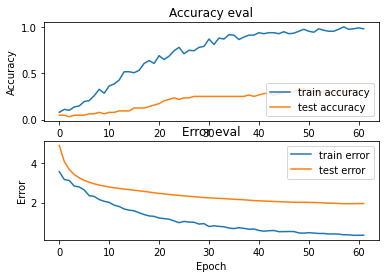

In [16]:
# plot accuracy and error as a function of the epochs
plot_history(history)

In [17]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

4/4 - 0s - loss: 2.1004 - acc: 0.3945

Test accuracy: 0.39449542760849


In [18]:
# pick a sample to predict from the test set
X_to_predict = X_test[15]
y_to_predict = y_test[15]

In [19]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [20]:
predict(model, X_to_predict, y_to_predict)

Target: 7, Predicted label: [9]
